# Step 1: Getting the stock price + volume data (yfinance)
**1.1 Install & import**

In [6]:
!pip install yfinance

In [7]:
import yfinance as yf
import pandas as pd

**1.2 Companies**

In [8]:
tickers = [
    "AAPL",   # Apple
    "MSFT",   # Microsoft
    "GOOGL",  # Google
    "AMZN",   # Amazon
    "META",   # Meta
]

**1.3 Download historical data**

In [9]:
data = yf.download(
    tickers,
    start="2019-01-01",
    end="2024-01-01",
    interval="1d",
    group_by="ticker",
    auto_adjust=True,
    progress=False
)

In [10]:
data.head()

Ticker            META                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2019-01-02  128.095206  136.556092  127.668181  134.738785  28146200   
2019-01-03  133.755643  136.218435  130.210402  130.826111  22717900   
2019-01-04  133.080386  137.042713  132.822195  136.993057  29002100   
2019-01-07  136.605755  137.906665  134.967207  137.092361  20089300   
2019-01-08  138.919589  142.147044  138.572011  141.541275  26263800   

Ticker           AAPL                                              ...  \
Price            Open       High        Low      Close     Volume  ...   
Date                                                               ...   
2019-01-02  36.818553  37.759877  36.661665  37.538807  148158800  ...   
2019-01-03  34.225167  34.638779  33.754506  33.799671  365248800  ...   
2019-01-04  34.355905  35.311491  34.182379  35.242554  234428400  ...   
2019-01-07  35.347148  35.378051  34.681566  35.164112  219111200  ...   
2019-01-08  35.551581  36.088803  35.304366  35.834454  164101200  ...   

Ticker           AMZN                                                  GOOGL  \
Price            Open       High        Low      Close     Volume       Open   
Date                                                                           
2019-01-02  73.260002  77.667999  73.046501  76.956497  159662000  50.974850   
2019-01-03  76.000504  76.900002  74.855499  75.014000  139512000  52.139546   
2019-01-04  76.500000  79.699997  75.915497  78.769501  183652000  51.737085   
2019-01-07  80.115501  81.727997  79.459503  81.475502  159864000  53.643187   
2019-01-08  83.234497  83.830498  80.830498  82.829002  177628000  53.892800   

Ticker                                                 
Price            High        Low      Close    Volume  
Date                                                   
2019-01-02  52.641756  50.879569  52.338547  31868000  
2019-01-03  52.913199  50.735156  50.888992  41960000  
2019-01-04  53.595048  51.454222  53.499271  46022000  
2019-01-07  53.729037  52.733560  53.392582  47446000  
2019-01-08  54.257544  53.016918  53.861538  35414000  

[5 rows x 25 columns]

**1.4 Reshape into a clean table**

In [11]:
dfs = []

for ticker in tickers:
    df_t = data[ticker].reset_index()
    df_t["ticker"] = ticker
    dfs.append(df_t)

stock_df = pd.concat(dfs, ignore_index=True)
stock_df.head()

Price,Date,Open,High,Low,Close,Volume,ticker
0,2019-01-02,36.818553,37.759877,36.661665,37.538807,148158800,AAPL
1,2019-01-03,34.225167,34.638779,33.754506,33.799671,365248800,AAPL
2,2019-01-04,34.355905,35.311491,34.182379,35.242554,234428400,AAPL
3,2019-01-07,35.347148,35.378051,34.681566,35.164112,219111200,AAPL
4,2019-01-08,35.551581,36.088803,35.304366,35.834454,164101200,AAPL


**1.5 Sanity check**

In [12]:
stock_df.isna().sum()
stock_df["ticker"].value_counts()

,count
ticker,
AAPL,1258
MSFT,1258
GOOGL,1258
AMZN,1258
META,1258


# Step 2: Feature Engineering + Emerging Trend Label
**2.1 Prep + basic features**

In [13]:
import numpy as np
import pandas as pd

# Make sure types + sorting are correct
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values(["ticker", "Date"]).reset_index(drop=True)

# Returns
stock_df["ret_1d"] = stock_df.groupby("ticker")["Close"].pct_change()
stock_df["log_ret_1d"] = np.log(stock_df["Close"]).groupby(stock_df["ticker"]).diff()

# Rolling moving averages (trend)
stock_df["ma_10"] = stock_df.groupby("ticker")["Close"].transform(lambda s: s.rolling(10).mean())
stock_df["ma_30"] = stock_df.groupby("ticker")["Close"].transform(lambda s: s.rolling(30).mean())

# Rolling volatility (risk / instability proxy)
stock_df["vol_20"] = stock_df.groupby("ticker")["log_ret_1d"].transform(lambda s: s.rolling(20).std())

# Volume attention features
stock_df["vol_avg_20"] = stock_df.groupby("ticker")["Volume"].transform(lambda s: s.rolling(20).mean())
stock_df["vol_ratio"] = stock_df["Volume"] / stock_df["vol_avg_20"]

**2.2 Define “emerging uptrend” label**

In [14]:
# Yesterday’s MA relationship (to detect crossover event)
prev_ma10 = stock_df.groupby("ticker")["ma_10"].shift(1)
prev_ma30 = stock_df.groupby("ticker")["ma_30"].shift(1)

cross_up = (stock_df["ma_10"] > stock_df["ma_30"]) & (prev_ma10 <= prev_ma30)
high_attention = stock_df["vol_ratio"] > 1.2

stock_df["emerging_trend"] = (cross_up & high_attention).astype(int)

**2.3 Drop rows with insufficient history**

In [15]:
model_df = stock_df.dropna(subset=["ret_1d", "ma_10", "ma_30", "vol_20", "vol_ratio"]).copy()

**2.4 Quick checks**

In [16]:
# How many trend events?
print(model_df["emerging_trend"].value_counts())

# Trend events per ticker
print(model_df.groupby("ticker")["emerging_trend"].sum().sort_values(ascending=False))

# Peek at some labeled events
model_df[model_df["emerging_trend"] == 1][["Date","ticker","Close","ma_10","ma_30","Volume","vol_ratio"]].head(10)

emerging_trend
0    6118
1      27
Name: count, dtype: int64
ticker
GOOGL    7
AMZN     6
META     5
MSFT     5
AAPL     4
Name: emerging_trend, dtype: int64


Price,Date,ticker,Close,ma_10,ma_30,Volume,vol_ratio
448,2020-10-12,AAPL,120.888908,112.802760,112.646948,240226800,1.559401
964,2022-10-28,AAPL,153.171295,144.807562,144.026650,164762400,1.861515
1057,2023-03-15,AAPL,150.946365,149.020451,148.735447,77167900,1.255483
1177,2023-09-06,AAPL,180.960358,181.841867,181.509690,81755800,1.532005
1299,2019-03-04,AMZN,84.808502,82.094501,81.990883,123348000,1.530885
1463,2019-10-24,AMZN,89.039001,88.262450,88.075250,88922000,1.585922
1503,2019-12-20,AMZN,89.324997,88.406950,88.316367,103016000,1.692833
1706,2020-10-12,AMZN,172.146500,160.274251,159.313183,167284000,1.584755
2148,2022-07-15,AMZN,113.550003,112.481001,112.441700,84317800,1.228226
2413,2023-08-04,AMZN,139.570007,130.860002,130.596001,153128500,2.456106


# Step 3: Predicting Emerging Market Trends via Price–Volume Dynamics
**Step 3.1 — Shift features**

In [17]:
features = [
    "ret_1d",
    "log_ret_1d",
    "ma_10",
    "ma_30",
    "vol_20",
    "vol_ratio"
]

# Shift features by 1 day per stock (predict future trend)
for col in features:
    model_df[col] = model_df.groupby("ticker")[col].shift(1)

model_df = model_df.dropna(subset=features + ["emerging_trend"])

**Step 3.2 — Train / test split**

In [18]:
train_df = model_df[model_df["Date"] < "2022-01-01"]
test_df  = model_df[model_df["Date"] >= "2022-01-01"]

X_train = train_df[features]
y_train = train_df["emerging_trend"]

X_test = test_df[features]
y_test = test_df["emerging_trend"]

**Step 3.3 — Train a model (logistic regression)**

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve

model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

**Step 3.4 — Evaluation**

In [20]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.998     0.513     0.678      2493
           1      0.008     0.833     0.016        12

    accuracy                          0.515      2505
   macro avg      0.503     0.673     0.347      2505
weighted avg      0.994     0.515     0.675      2505



In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
}).head()

,threshold,precision,recall
0,0.004817,0.004790,1.0
1,0.006185,0.004792,1.0
2,0.006752,0.004794,1.0
3,0.007170,0.004796,1.0
4,0.007185,0.004798,1.0


**Ranking-Based Evaluation**

In [26]:
# Rank predictions
test_df = test_df.copy()
test_df["prob"] = y_prob
test_df = test_df.sort_values("prob", ascending=False)

for k in [5, 10, 20, 50]:
    precision_at_k = test_df.head(k)["emerging_trend"].mean()
    print(f"Precision@{k}: {precision_at_k:.3f}")

Precision@5: 0.000
Precision@10: 0.000
Precision@20: 0.000
Precision@50: 0.000


In [27]:
baseline = y_test.mean()
baseline

np.float64(0.004790419161676647)

**Visualization of Emerging Trend Signals Across Stocks**

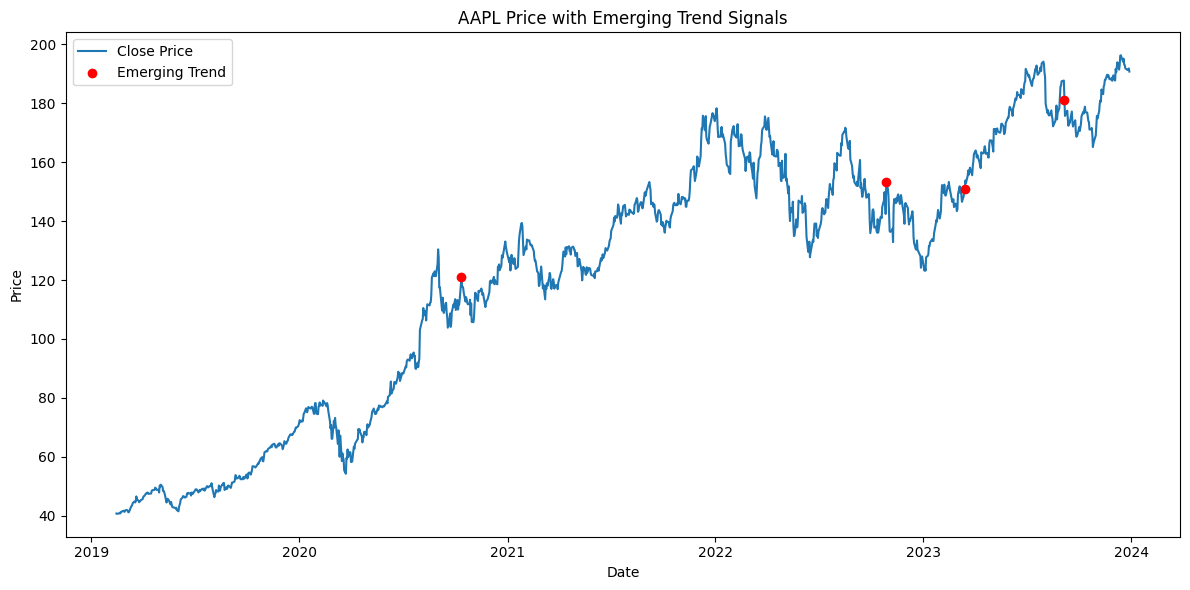

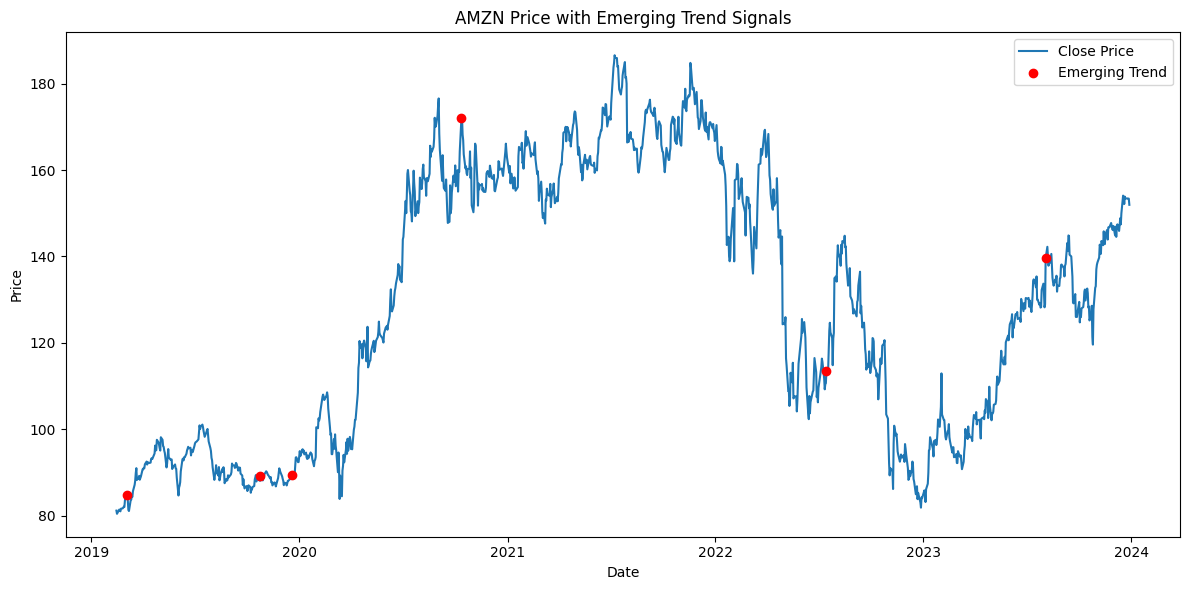

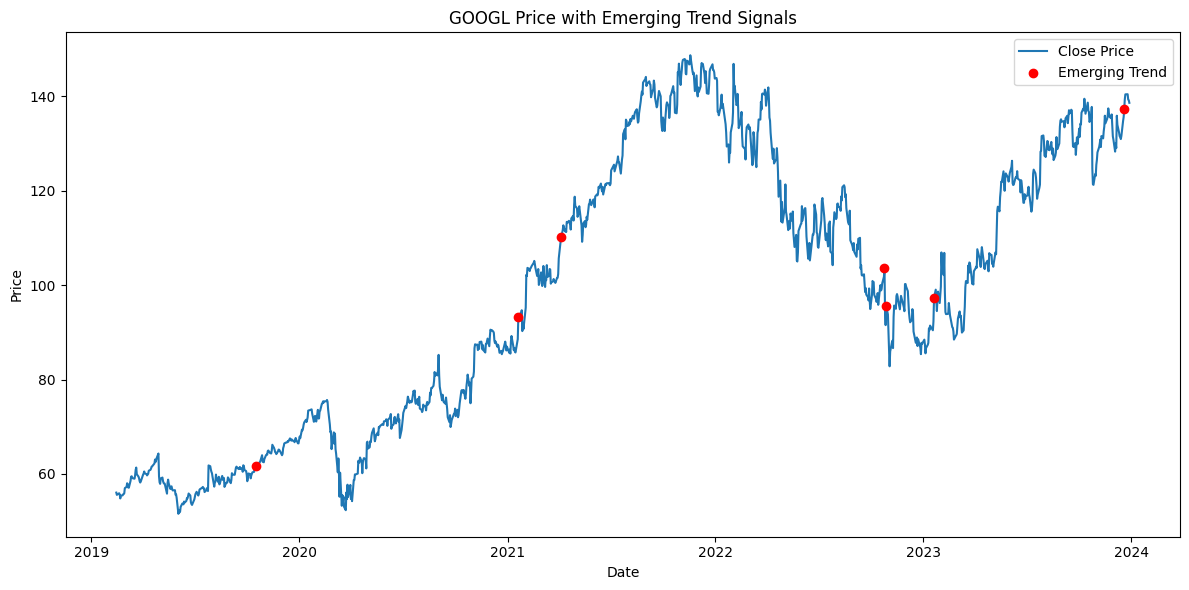

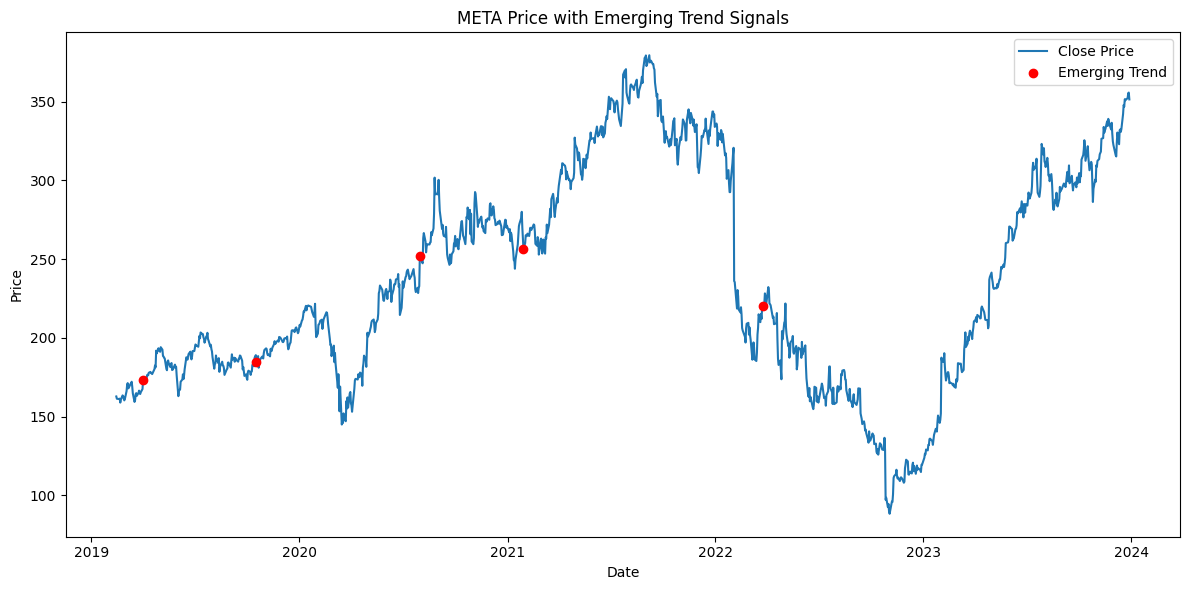

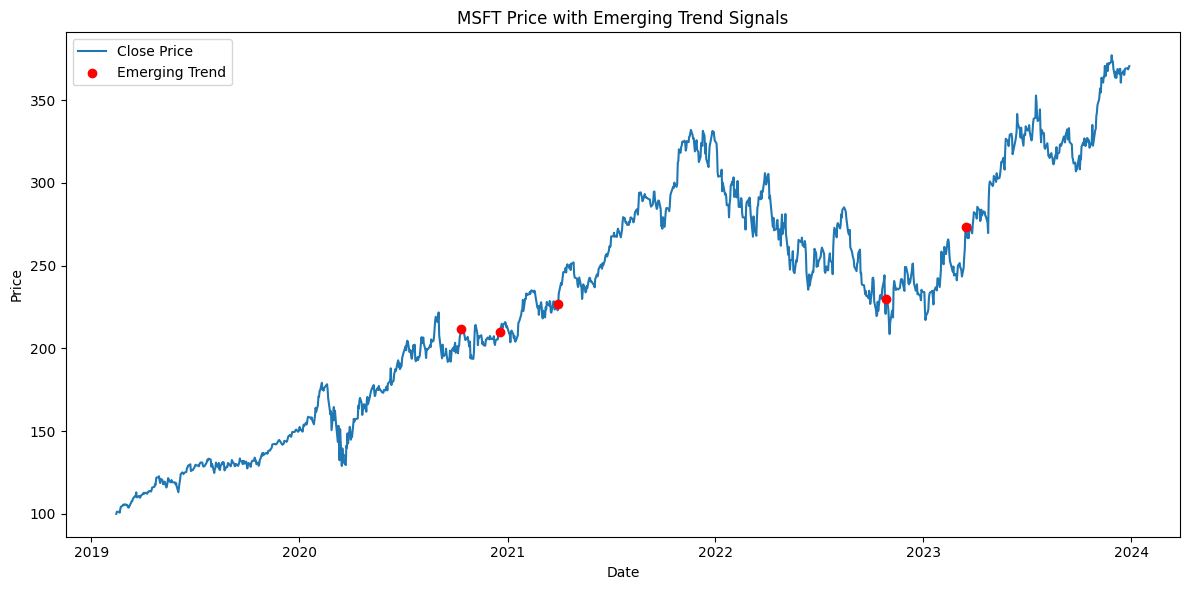

In [28]:
import matplotlib.pyplot as plt

tickers = model_df["ticker"].unique()

for ticker in tickers:
    plot_df = model_df[model_df["ticker"] == ticker]

    plt.figure(figsize=(12, 6))
    plt.plot(plot_df["Date"], plot_df["Close"], label="Close Price")

    trend_points = plot_df[plot_df["emerging_trend"] == 1]
    plt.scatter(
        trend_points["Date"],
        trend_points["Close"],
        color="red",
        label="Emerging Trend",
        zorder=5
    )

    plt.title(f"{ticker} Price with Emerging Trend Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

In this project, we used stock price and trading volume to study how trends start in the stock market. We treated higher trading activity as a sign of human attention and defined emerging trends as early changes in price direction. The model was able to detect some early trend signals despite the data being noisy and imbalanced. This shows that simple price and volume data can be used to identify emerging market trends.